# Reinforcement Learning
# TP 2 - The Exploration-Exploitation Dilemma

Student: Pierre-Louis Guhur

# 1. Stochastic Multi-Armed Bandits on Simulated Data

## 1.1 Bernoulli bandit models

**A multi-armed bandit model is a collection of arms:
                                ```MAB = {Arm1, Arm2, ...,ArmK}```
Start by defining your own Bernoulli bandit model with K arms of means $p_1, . . . , p_K$**

In [2]:
from arms import *
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, log 
from IPython.display import display, clear_output
import time


K = 10
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

***1.* Write two functions
              `[rew,draws]=UCB1(T,MAB,...)` and `[rew,draws]=TS(T,MAB,...)`
simulating a bandit game of length $T$ with the UCB1 and Thompson Sampling strategy on the bandit model MAB: `rew` and `draws` are the sequence of the $T$ rewards obtained and of the $T$ the arms drawn.**

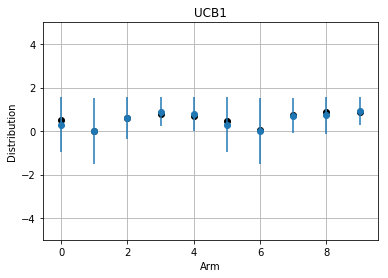

In [23]:

def _update_empirical_mean(mu, value, N):
    ''' Online update of the emperical mean '''
    return N/(N+1) * mu + 1/(N+1) * value


def _update_ucb(B, mu, N, t, rho=sqrt(3)):
    K = len(B)
    for i in range(K):
        B[i] = mu[i] + rho*sqrt(log(t)/N[i])
        

def plot_UCB1(B, mu, gt=None, sleep=0.1):
    K = len(mu)
    plt.cla()
    ax = plt.gca()
    plt.errorbar(x=range(K), y=mu, yerr=(B-mu), fmt='o')
    plt.grid()
    plt.ylim(-5, 5)
    if gt is not None:
        plt.scatter(range(0, K), gt, color="k", label="ground truth")
    plt.draw()
    plt.xlabel("Arm")
    plt.ylabel("Distribution")
    plt.title("UCB1")
    time.sleep(sleep)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)
    
    
def UCB1(T, MAB, rho=sqrt(3), vis="all"):
    """The UCB1 algorithm starts with an initialization phase that draws each arm once, and for t ≥ K, chooses at time t + 1 arm
    $$A_{t+1} = argmax_{a\in{1,...,K }} = \hat{\mu}_a(t) + \rho_t \sqrt{\frac{\log t}{2N_a(t)}}$$
    """
    K = len(MAB) # number of arms
    mu = np.zeros(K) # empirical mean
    N = np.zeros(K) # number of times an arm was pulled
    B = np.zeros(K) # upper-confidence bound
    gt = [m.mean for m in MAB] # ground-truth
    draws = np.zeros(T+1)
    rew = np.zeros(T+1)
    
    # initialisation
    for i in range(K):
        s = MAB[i].sample()
        mu[i] = _update_empirical_mean(0, s, 0)
        B[i] = mu[i] + 0
        N[i] += 1
        draws[i] = i
        rew[i] = s
    
    # steps
    for t in range(K, T+1):
        _update_ucb(B, mu, N, t, rho=rho)
        a = np.argmax(B)
        s = MAB[a].sample()
        mu[a] = _update_empirical_mean(mu[a], s, N[a])
        N[a] += 1
        draws[i] = a
        rew[i] = s
        
        if vis == "all":
            plot_UCB1(B, mu, gt=gt, sleep=1e-3)
        
    return rew, draws

rew, draws = UCB1(200, MAB)

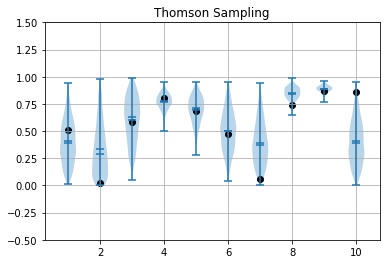

In [20]:
def _update_posterior(p, a, b):
    K = len(p)
    for i in range(K):
        p[i] = np.random.beta(a[i], b[i])
        
def plot_TS(a, b, gt=None, size=1000, sleep=1e-2):
    K = len(a)
    plt.cla()
    ax = plt.gca()
    all_data = [np.random.beta(a[i], b[i], size=size) for i in range(K)]
    plt.violinplot(all_data, showmeans=True, showmedians=True)
    if gt is not None:
        plt.scatter(range(1, K+1), gt, color="k", label="ground truth")
    plt.grid()
    plt.ylim(-0.5, 1.5)
    plt.xlabel("Arm")
    plt.ylabel("Distribution")
    plt.draw()
    plt.title("Thomson Sampling")
    time.sleep(sleep)
    display(plt.gcf(), display_id=True)
    clear_output(wait=True)
    
    
def TS(T, MAB, rho=sqrt(3), vis="all"):
    """The UCB1 algorithm starts with an initialization phase that draws each arm once, and for t ≥ K, chooses at time t + 1 arm
    $$A_{t+1} = argmax_{a\in{1,...,K }} = \hat{\mu}_a(t) + \rho_t \sqrt{\frac{\log t}{2N_a(t)}}$$
    """
    K = len(MAB) # number of arms
    p = np.random.random(K) # prior distribution
    a = np.ones(K) # beta - a
    b = np.ones(K) # beta - b
    gt = [m.mean for m in MAB] # ground-truth
    draws = np.zeros(T+1)
    rew = np.zeros(T+1)

    
    # steps
    for t in range(1, T+1):
        _update_posterior(p, a, b)
        A = np.argmax(p)
        s = MAB[A].sample()
        a[A] += s
        b[A] += 1-s
        draws[t] = A
        rew[t] = s
        
        if vis == "all":
            plot_TS(a, b, gt=gt, sleep=1e-3)
        
    return rew, draws

rew, draws = TS(200, MAB)

***2.* Based on many simulations, estimate the expected regret of UCB1 and Thompson Sampling and display regret curves.
You may also add the naive strategy that selects the empirical best arm at each round.**